In [1]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Calculation of historical volatility using data from yahoo finance

def volatility(ticker, time_period):
    """
    Inputs:
    
    ticker symbol = e.g., 'TSLA'
    time period = e.g., '1y'
    
    Output: 
    
    volatility (standard deviation) of stock price daily returns
    
    """
    
    df = yf.Ticker(ticker).history(period=time_period)
    df_logretn = np.log(df['Close'] / df['Close'].shift(1)) # log return
    #df_raw_retn = df['Close'].pct_change() # raw return 
    volatility = (df_logretn.rolling(window=252).std() * np.sqrt(252)).iloc[-1]
    
    # Taking into account the dividend yield if needed
    divd = df['Dividends']
    divd_last_year = divd[divd.index > (divd.index.max() - pd.DateOffset(years=1))].sum()
    divd_yield = divd_last_year / df['Close'].iloc[-1] 
    
    return volatility, divd_yield

In [3]:
# Get the (1 year) risk-free interest rate from FRED (Federal Reserve Economic Data) 

import pandas_datareader as pdr

rf_rate_list = pdr.DataReader('DGS1', 'fred')
rf_rate = rf_rate_list['DGS1'].iloc[-1]/100

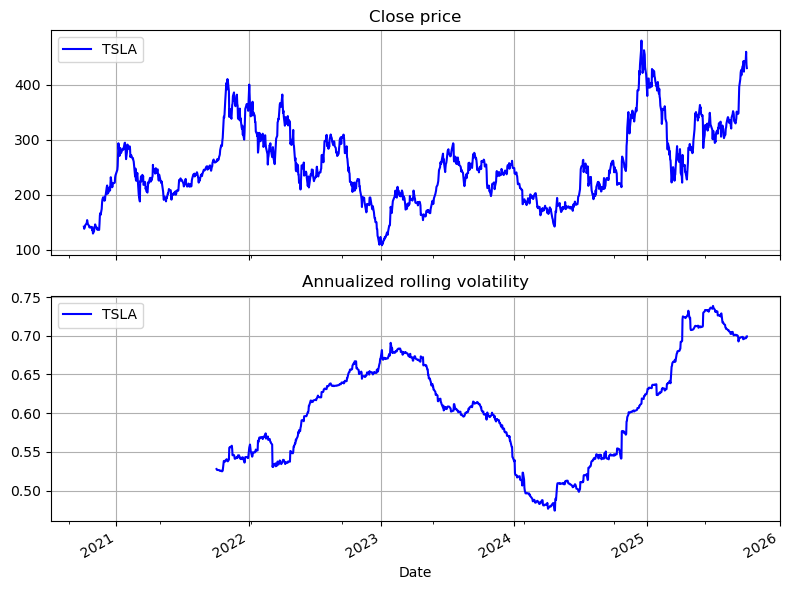

In [4]:
# Example

ticker = 'TSLA'
time_period = '5y'
df = yf.Ticker(ticker).history(period = time_period)
df_logretn = np.log(df['Close'] / df['Close'].shift(1))                # log return
df['Volatility'] = df_logretn.rolling(window=252).std() * np.sqrt(252) # rolling standard deviation (annualized) 
axes = df[['Close', 'Volatility']].plot(subplots=True, grid=True, sharex=True, color='blue',figsize=(8, 6))
axes[0].set_title('Close price')
axes[0].legend([f'{ticker}']) 

axes[1].set_title('Annualized rolling volatility')
axes[1].legend([f'{ticker}']) 

plt.tight_layout() # adjust layout to prevent titles from overlapping
plt.show()

In [5]:
# Define Greek letters in one function using Black-Scholes model

def Greeks(S, K, T, sigma, r, q, letter):
    """
    Inputs:
    
    S: stock price
    K: strike price
    T: time to expiry
    sigma: volatility
    r: risk-free interest rate
    q: dividend yield
    letter: 'call_delta', 'put_delta', 'call_gamma', 'put_gamma', 'call_theta', 'put_theta', 'call_vega', 'put_vega', 'call_rho', 'put_rho'
    
    """
    d_1 = (np.log(S/K) + (r + ((sigma**2)/2)) * T) / (sigma * math.sqrt(T))
    d_2 = d_1 - sigma * math.sqrt(T)

    if letter == 'call_delta':
        G = np.exp(- q* T) * norm.cdf(d_1)
        
    elif letter == 'put_delta':
        G = np.exp(- q* T) * (norm.cdf(d_1) - 1)
        
    elif letter == 'call_gamma':
        G = np.exp(- q* T) * norm.pdf(d_1) / (S * sigma * math.sqrt(T))
        
    elif letter == 'put_gamma':
        G = np.exp(- q* T) * norm.pdf(d_1) / (S * sigma * math.sqrt(T))
        
    elif letter == 'call_theta':
        G = - S * norm.pdf(d_1) * sigma * np.exp(- q* T) / (2 * math.sqrt(T)) + q * S * norm.cdf(d_1) * np.exp(- q* T) - r * K * np.exp(- r * T) * norm.cdf(d_2)
    
    elif letter == 'put_theta': 
        G = - S * norm.pdf(d_1) * sigma * np.exp(- q* T) / (2 * math.sqrt(T)) - q * S * norm.cdf(-d_1) * np.exp(- q* T) + r * K * np.exp(- r * T) * norm.cdf(- d_2)
    
    elif letter == 'call_vega':
        G = S * norm.pdf(d_1) * math.sqrt(T) * np.exp(- q* T)
    
    elif letter == 'put_vega':
        G = S * norm.pdf(d_1) * math.sqrt(T) * np.exp(- q* T)
    
    elif letter == 'call_rho':
        G = K * T * np.exp(-r *T) * norm.cdf(d_2)
    
    elif letter == 'put_rho':
        G = -K * T * np.exp(-r * T) * norm.cdf(- d_2)
    
    return G

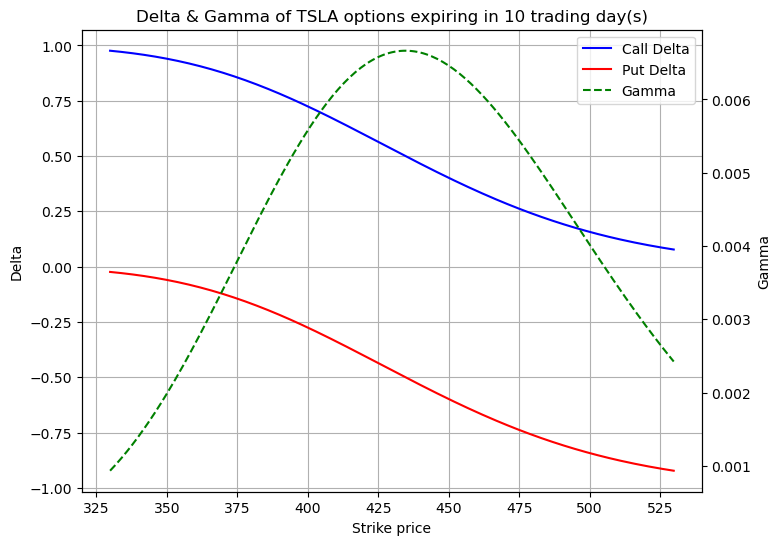

In [6]:
# Delta & Gamma w.r.t. changes in strike price

S = df['Close'].iloc[-1]  # current price
D = 10                    # time to expiry in days
T = D/252                 # time to expiry in years
sigma = df['Volatility'].iloc[-1]
r = rf_rate
q = volatility(ticker,time_period)[1]

strikes = np.linspace(S-100, S+100, 201)

call_deltas = []
put_deltas = []

for K_d in strikes:
    c_d = Greeks(S, K_d, T, sigma, r, q, 'call_delta')
    p_d = Greeks(S, K_d, T, sigma, r, q, 'put_delta')
    call_deltas.append(c_d)
    put_deltas.append(p_d)

delta = pd.DataFrame({
    'Strike': strikes,
    'Call': call_deltas,
    'Put': put_deltas
}).set_index('Strike')

gammas = []

for K_g in strikes:
    gam = Greeks(S, K_g, T, sigma, r, q, 'call_gamma')
    gammas.append(gam)

gamma = pd.DataFrame({
    'Strike': strikes,
    'Call or Put': gammas,
}).set_index('Strike')


fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot(delta.index, delta['Call'], label="Call Delta", color="blue")
ax1.plot(delta.index, delta['Put'], label="Put Delta", color="red")
ax1.set_xlabel("Strike price")
ax1.set_ylabel("Delta")
ax1.grid(True)

# y-axis for Gamma
ax2 = ax1.twinx()
ax2.plot(gamma.index, gamma['Call or Put'], label="Gamma", color="green", linestyle="--")
ax2.set_ylabel("Gamma")
    
# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title(f'Delta & Gamma of {ticker} options expiring in {D} trading day(s)')
plt.show()

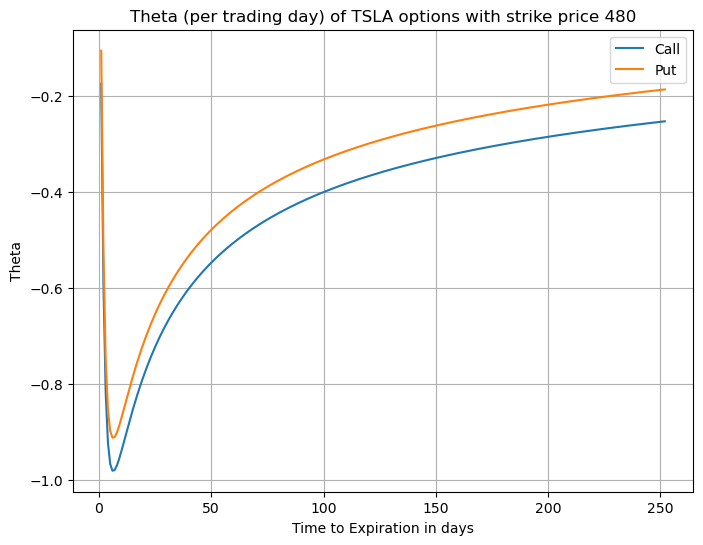

In [7]:
# Theta w.r.t. different time to expiration

S = df['Close'].iloc[-1] 
K = 480
sigma = df['Volatility'].iloc[-1]
r = rf_rate
q = volatility(ticker,time_period)[1]

TtE = np.linspace(1, 252, 252) 
call_thetas = []
put_thetas = []

for T_t in TtE:
    c_t = Greeks(S, K, T_t/252, sigma, r, q, 'call_theta')/252 # per trading day
    p_t = Greeks(S, K, T_t/252, sigma, r, q, 'put_theta')/252
    call_thetas.append(c_t)
    put_thetas.append(p_t)

theta = pd.DataFrame({
    'Time to Expiration': TtE,
    'Call': call_thetas,
    'Put': put_thetas
}).set_index('Time to Expiration')
    

theta[['Call','Put']].plot(grid=True,figsize=(8,6))
plt.title(f'Theta (per trading day) of {ticker} options with strike price {K}')
plt.xlabel("Time to Expiration in days")
plt.ylabel("Theta")
plt.legend()
plt.grid(True)
plt.show()

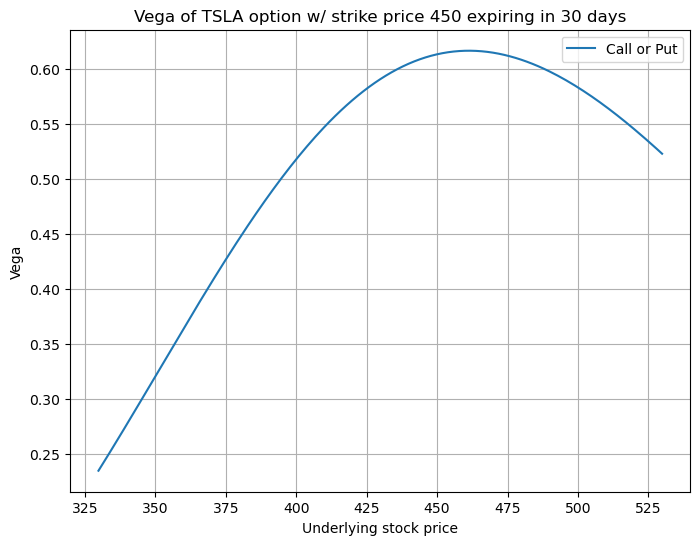

In [8]:
# Vega w.r.t. changes in underlying stock price

S = df['Close'].iloc[-1] 
K = 450
D = 30
T = D/252
sigma = df['Volatility'].iloc[-1]
r = rf_rate
q = volatility(ticker,time_period)[1]

stock_prices = np.linspace(S-100, S+100, 201)
vegas = []

for stock_price in stock_prices:
    vega = Greeks(stock_price, K, T, sigma, r, q, 'call_vega')/100
    vegas.append(vega)

vega = pd.DataFrame({
    'Stock price': stock_prices,
    'Call or Put': vegas
}).set_index('Stock price')
    

vega['Call or Put'].plot(grid=True,figsize=(8,6))
plt.title(f'Vega of {ticker} option w/ strike price {K} expiring in {D} days')
plt.xlabel("Underlying stock price")
plt.ylabel("Vega")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Next we plot the IV

def option_chains(ticker):
    """
    Input:
    
    ticker = e.g., 'SPY'
    
    """
    asset = yf.Ticker(ticker)
    expiration_dates = asset.options
    
    chains = pd.DataFrame()
    
    for expiration in expiration_dates:
        opt = asset.option_chain(expiration)
        
        calls = opt.calls
        calls['optionType'] = "call"
        
        puts = opt.puts
        puts['optionType'] = "put"
        
        chain = pd.concat([calls, puts])
        chain['expiration'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59) # pd.to_datetime converts a scalar, array-like, DataFrame to a pandas datetime object
                                
        
        chains = pd.concat([chains, chain])
    
    chains["daysToExpiration"] = (chains.expiration - dt.datetime.today()).dt.days + 1
    
    return chains

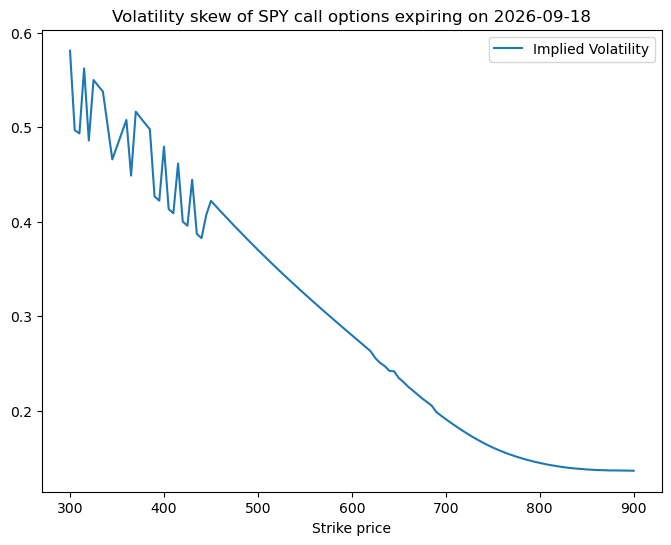

In [10]:
optionChains = option_chains('SPY')
calls = optionChains[optionChains['optionType'] == 'call']

call_at_expiry = calls[calls['expiration'] == '2026-09-18 23:59:59']

call_at_expiry = call_at_expiry[call_at_expiry.impliedVolatility >= 0.001] # remove entries with very low IV

call_at_expiry[['strike', 'impliedVolatility']].set_index('strike').plot(
    title='Volatility skew of SPY call options expiring on 2026-09-18', figsize=(8, 6)
)
plt.xlabel('Strike price')
plt.legend(['Implied Volatility'])

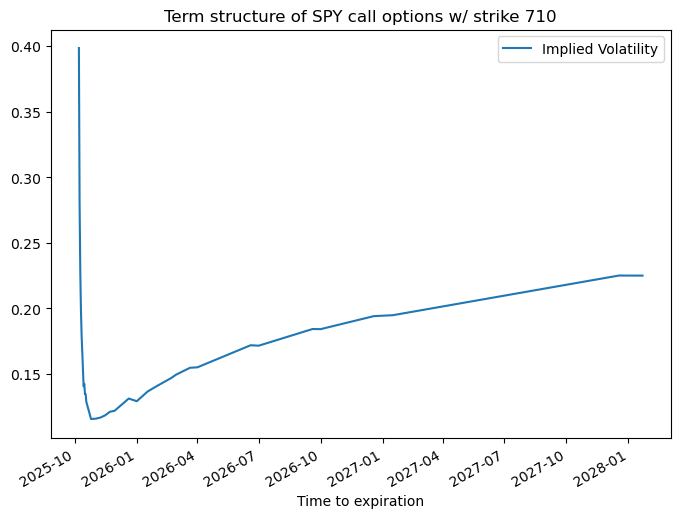

In [11]:
calls_at_strike = calls[calls["strike"] == 710]

calls_at_strike = calls_at_strike[calls_at_strike.impliedVolatility >= 0.001]

calls_at_strike[["expiration", "impliedVolatility"]].set_index("expiration").plot(
    title="Term structure of SPY call options w/ strike 710", figsize=(8, 6)
)
plt.xlabel('Time to expiration')
plt.legend(['Implied Volatility'])

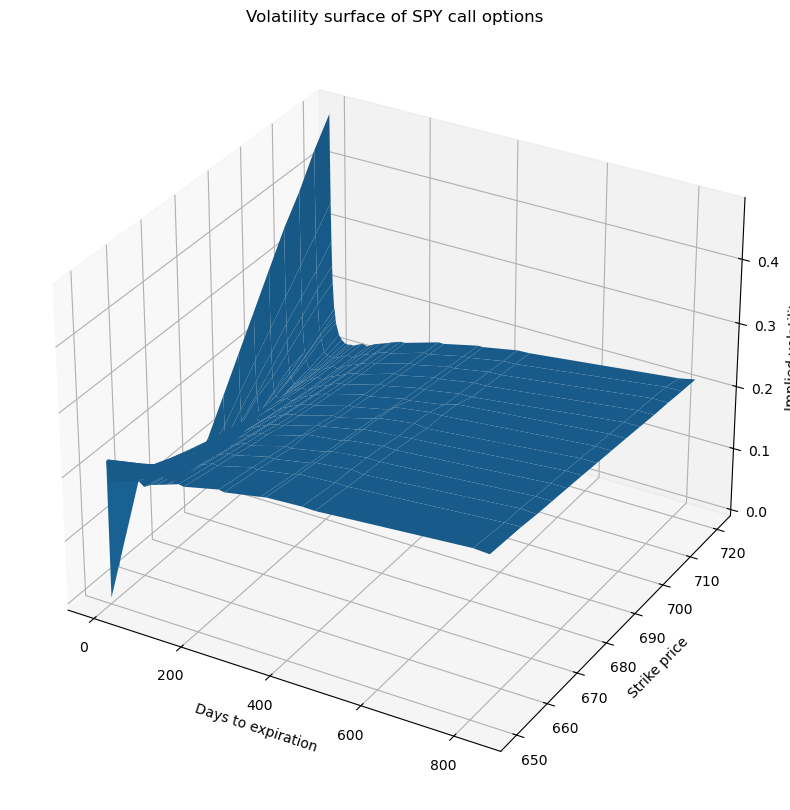

In [12]:
surface = (                                                                              #so surface becomes a 2D matrix
    calls[['daysToExpiration', 'strike', 'impliedVolatility']]
    .pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration') #rearranges the data into a grid
    .dropna()
)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')  # 111 = (nrows, ncols, position of this subplot); make a 1×1 grid of subplots

x, y, z = surface.columns.values, surface.index.values, surface.values  

#x = array of days to expiration (columns)

#y = array of strike prices (index)

#z = 2D array of implied volatility values (the pivot table contents)

# expands x (days) and y (strikes) into full 2D coordinate matrices
X, Y = np.meshgrid(x, y) #aligns with the shape of

# label axes
ax.set_xlabel('Days to expiration')
ax.set_ylabel('Strike price')
ax.set_zlabel('Implied volatility')
ax.set_title('Volatility surface of SPY call options')
ax.plot_surface(X, Y, z)